In [ ]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import get_scorer
from datetime import datetime

from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

import json

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

In [ ]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [ ]:
x = compute_features(df.drop('mortality',axis=1)) #df.drop('mortality',axis=1)
y = df.mortality.values


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

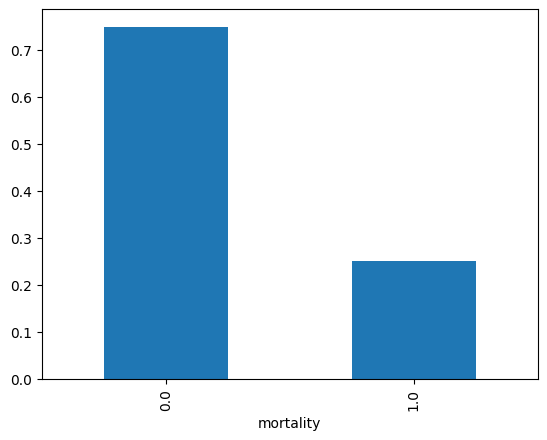

In [ ]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [ ]:
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]


# GridSearchCV for weight of weighted loss

### Probit

In [ ]:
probit_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=10)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model',probitModel()),
]

In [ ]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('iso_forest',
                                        FeatureTransformer(fnames=Index(['Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min',
       'Fraction inspired oxygen_max', 'Glucose_mean', 'Glucose_min',
       'Glucose_max', 'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',
       'Mean blood pressure...
       'Temperature_max_to_mean', 'Weight_min_to_mean', 'Weight_max_to_mean',
       'pH_min_to_mean', 'pH_max_to_mean'],
      dtype='object'))),
                                       ('imputer', KNNImputer(n_neighbors=10)),
                                       ('model', probitModel())]),
             n_jobs=-1,
             param_grid={'model__w': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=3)

In [ ]:
search.best_params_

{'model__w': 0.7500000000000002}

### Logistic Model

In [ ]:
logistic_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=10)),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
    ('model', logisticModel()),
]

In [ ]:
pipe = Pipeline(probit_pipeline)
param_grid = {
    'model__w': np.arange(0.1,1.0,0.05),
}
search = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3)
search.fit(x,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('iso_forest',
                                        FeatureTransformer(fnames=Index(['Fraction inspired oxygen_mean', 'Fraction inspired oxygen_min',
       'Fraction inspired oxygen_max', 'Glucose_mean', 'Glucose_min',
       'Glucose_max', 'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',
       'Mean blood pressure...
       'Temperature_max_to_mean', 'Weight_min_to_mean', 'Weight_max_to_mean',
       'pH_min_to_mean', 'pH_max_to_mean'],
      dtype='object'))),
                                       ('imputer', KNNImputer(n_neighbors=10)),
                                       ('model', probitModel())]),
             n_jobs=-1,
             param_grid={'model__w': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=3)

In [ ]:
search.best_params_

{'model__w': 0.7500000000000002}

# Bayes Opt

## Probit

In [ ]:
def probit_cv(l1, l2, n_neighbors):
    probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(n_neighbors))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(n_neighbors))),
        ('model',probitModel( l1=l1, l2=l2, w=0.75 )),
    ]
    mean_score = cv(probit_pipeline, x.values, y, f1_score, 5, random_state=SEED, path='probit')

    return mean_score

In [ ]:
bo = BayesianOptimization(
    probit_cv, 
    pbounds={
        'l1':(0,2),
        'l2':(0,2),
        'n_neighbors':(5,20)
    },                              
    verbose=2
)

In [ ]:


start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   |    l1     |    l2     | n_neig... |
-------------------------------------------------------------
| 1         | 0.3987    | 0.1166    | 1.722     | 5.002     |
| 2         | 0.4052    | 0.2119    | 1.409     | 18.68     |
| 3         | 0.3844    | 1.28      | 1.781     | 6.535     |
| 4         | 0.3937    | 0.6662    | 0.997     | 12.6      |
| 5         | 0.3878    | 0.3511    | 1.737     | 10.81     |
| 6         | 0.3823    | 0.7184    | 1.472     | 8.056     |
| 7         | 0.3613    | 0.9539    | 0.5867    | 16.95     |
| 8         | 0.4034    | 0.5929    | 0.7634    | 6.428     |
| 9         | 0.3665    | 1.742     | 1.118     | 7.23      |
| 10        | 0.4008    | 0.1611    | 1.764     | 18.8      |
| 11        | 0.4112    | 0.07938   | 0.8207    | 5.673     |
| 12        | 0.3691    | 0.6539    | 0.07086   | 5.114     |
| 13        | 0.4044    | 0.01793   | 1.444     | 6.069     |
| 14        | 0.3881    | 0.03082   | 0.2145    | 6.425     |
| 15    

In [ ]:
print(bo.max)

{'target': 0.48161744129227124, 'params': {'l1': 0.002988761334869139, 'l2': 0.01946744944027845, 'n_neighbors': 19.65784708642015}}


In [ ]:
with open('probit.json', 'w') as f:
    json.dump(bo.max['params'], f)

## Logistic

In [ ]:
def logistic_cv(l1, l2, n_neighbors):

    logistic_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(n_neighbors))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(n_neighbors))),
        ('model', logisticModel(l1=l1, l2=l2, w=0.75)),
    ]

    mean_score = cv(logistic_pipeline, x.values, y, f1_score, 5, random_state=SEED, path='logistic')

    return mean_score

In [ ]:
bo = BayesianOptimization(
    logistic_cv, 
    pbounds={
        'l1':(0,2),
        'l2':(0,2),
        'n_neighbors':(5,20)
    },                              
    verbose=2
)

In [ ]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   |    l1     |    l2     | n_neig... |
-------------------------------------------------------------
| 1         | 0.3925    | 0.6362    | 0.6183    | 15.75     |
| 2         | 0.3848    | 1.205     | 1.009     | 8.682     |
| 3         | 0.3603    | 1.397     | 0.1356    | 16.08     |
| 4         | 0.3896    | 0.6312    | 0.6643    | 15.76     |
| 5         | 0.3607    | 0.6617    | 0.4385    | 15.43     |
| 6         | 0.3607    | 0.6955    | 0.5281    | 15.88     |
| 7         | 0.36      | 1.142     | 0.3888    | 15.82     |
| 8         | 0.3913    | 0.5034    | 0.5803    | 15.73     |
| 9         | 0.3862    | 0.6346    | 0.7134    | 15.66     |
| 10        | 0.3829    | 0.4229    | 0.7919    | 15.64     |
| 11        | 0.381     | 0.6219    | 0.8806    | 9.992     |
| 12        | 0.3876    | 0.8367    | 0.8313    | 9.73      |
| 13        | 0.3705    | 0.394     | 0.01235   | 13.46     |
| 14        | 0.3829    | 0.8599    | 0.9929    | 9.816     |
| 15    

In [ ]:
print(bo.max)

{'target': 0.4329753018056152, 'params': {'l1': 0.014292621207035117, 'l2': 0.30100023196624015, 'n_neighbors': 10.69465892778601}}


In [ ]:
with open('logistic.json', 'w') as f:
    json.dump(bo.max['params'], f)

## LightGBM

In [ ]:


def lightgbm_cv(
        max_depth, num_leaves, 
        min_data_in_leaf, bagging_fraction, 
        feature_fraction, lambda_l1, lambda_l2,
        min_split_gain, max_bin, drop_rate, max_drop,
        n_neighbors
    ):
    params = {
        "objective": "binary",
        "metric": None,
        "verbosity": -1,
        "boosting_type": "dart",#"gbdt", #
        "is_unbalance": True,
        "num_boost_round": 1000,
        "learning_rate" : 0.03,

        "max_depth" : int(max_depth),
        "num_leaves" : int(num_leaves),
        "min_data_in_leaf": int(min_data_in_leaf),
        "bagging_fraction": bagging_fraction,
        "feature_fraction": feature_fraction,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "min_split_gain": min_split_gain,
        "max_bin": int(max_bin),
        # dart param
        "drop_rate": drop_rate,
        "max_drop": int(max_drop)
    }

    lightgbm_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(n_neighbors))),
        #('imputer', KNNImputer(missing_values=np.nan, n_neighbors=10)),
        ('model', LGBMClassifier(**params)),
    ]

    mean_score = cv(lightgbm_pipeline, x.values, y, f1_score, 5, random_state=SEED, path='lightgbm')

    return mean_score

In [ ]:
bo = BayesianOptimization(
    lightgbm_cv, 
    pbounds={
        "max_depth" : (3, 10),
        "num_leaves" : (20, 100),
        "min_data_in_leaf": (1, 50),
        "bagging_fraction": (0.5, 1.0),
        "feature_fraction": (0.5, 1.0),
        "lambda_l1": (0, 10),
        "lambda_l2": (0, 10),
        "min_split_gain": (0, 0.1),
        "max_bin": (50,255),
        # dart param
        "drop_rate": (0,0.5),
        "max_drop": (10,50),
        # KNN imputer
        'n_neighbors':(5,20)
    },                              
    verbose=2
)

In [ ]:
start = datetime.now()

bo.maximize(init_points=3, n_iter=100)

time_elapsed = datetime.now() - start

print('Time elapsed:',time_elapsed)

|   iter    |  target   | baggin... | drop_rate | featur... | lambda_l1 | lambda_l2 |  max_bin  | max_depth | max_drop  | min_da... | min_sp... | n_neig... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.497     | 0.5174    | 0.4146    | 0.5894    | 9.354     | 4.818     | 136.9     | 7.974     | 22.91     | 44.85     | 0.06339   | 11.68     | 72.6      |
| 2         | 0.4851    | 0.7264    | 0.4458    | 0.8883    | 7.17      | 9.075     | 238.5     | 9.973     | 39.41     | 49.02     | 0.04627   | 11.71     | 98.98     |
| 3         | 0.4983    | 0.7876    | 0.06016   | 0.8814    | 1.719     | 8.902     | 56.31     | 5.555     | 18.13     | 3.419     | 0.03156   | 15.34     | 27.5      |
| 4         | 0.4965    | 0.5775    | 0.1515    | 0.9369    | 1.863     | 4.557     | 58.41     | 6.173     | 14.65     | 6.841     | 0.09813   | 11.9

In [ ]:
print(bo.max)

{'target': 0.5173328709439835, 'params': {'bagging_fraction': 0.5865248104397857, 'drop_rate': 0.33084258717966025, 'feature_fraction': 0.671738783069191, 'lambda_l1': 9.929229226648596, 'lambda_l2': 5.431250162844944, 'max_bin': 54.610448631060244, 'max_depth': 3.0086886259593664, 'max_drop': 28.6401980356557, 'min_data_in_leaf': 7.418552279225327, 'min_split_gain': 0.024435556109166024, 'n_neighbors': 5.6700955505594095, 'num_leaves': 39.24235073196665}}


In [33]:
with open('lightGBM.json', 'w') as f:
    json.dump(bo.max['params'], f)

### lightGBM - cross validation

In [ ]:
with open('lightgbm.json','r') as f:
    lightgbm_param = json.load(f)

In [ ]:
#https://www.kaggle.com/code/adrianlievano/light-gbm-with-stratified-kfold

import lightgbm as lgb
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cv_result=list()
f1_result=list()
acc_result=list()
cr_report=list()

skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

skf.get_n_splits(X_test, y_test)

dec_threshold=0.5



for fold, (train_index, test_index) in enumerate(skf.split(X_test, y_test)):
    k_X_train, k_X_test = x.values[train_index], x.values[test_index]
    k_y_train, k_y_test = y.values[train_index], y.values[test_index]


    """
    model_cv = lgb.cv(
            params=lightgbm_param,
            train_set=k_X_train,
            num_boost_round=100,
            feval = f1_metric,
            )
    """

    k_y_pred_prob=model_cv.predict(k_X_test)
    k_y_pred=k_y_pred_prob>dec_threshold

    cm_cv = confusion_matrix(k_y_test, k_y_pred)
    cv_result.append(cm_cv)
    f1_result.append(f1_score(k_y_test, k_y_pred))
    acc_result.append(accuracy_score(k_y_test, k_y_pred))
    cr_report.append(classification_report(k_y_test, k_y_pred))



#print(len(all_mse_val))


In [ ]:


cm_matrix=list()
axes=np.empty((2, 2), dtype=object)



fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(10, 8))
fig.suptitle("K folds validation")
fig.subplots_adjust(wspace=0.01)


# Plot each subplot
for k in range(4):
    row = k // 2
    col = k % 2
    #cm_matrix=cv_result[k]
    cm_matrix.append(pd.DataFrame(data=cv_result[k], columns=['Actual:1', 'Actual:0'],
                                 index=['Predict:1', 'Predict:0']))
    #axes[row][col].set_title(f'set: {k+1},\n accuracy:{round(acc_result[k],2)}, \nF1 score: {round(f1_result[k],2)}')
    axes[row][col].set_title(f'set: {k+1} {cr_report[k]}', fontsize=10)
    sns.heatmap(cm_matrix[k], annot=True, fmt='d',ax=axes[row][col], cmap='YlGnBu')


plt.tight_layout()